# Realiza el Entrenamiento del Modelo para Detección de los Operadores de un Cursograma usando los modelos provistos por TensorFlow versión 2

Fuentes:

- original con TF1 -> https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/

- nuevo para TF2 -> https://towardsdatascience.com/how-to-train-a-tensorflow-2-object-detection-model-25d4da64b817 +  https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=fF8ysCfYKgTP&uniqifier=1


1) Preparar el ambiente: 

In [1]:
#@title Actualizar e instalar paquetes necesarios
##%tensorflow_version 2.x
##import tensorflow as tf
##!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim
!pip install pycocotools

     |████████████████████████████████| 358kB 8.4MB/s 


In [6]:
#@title Clona el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

##if "models" in pathlib.Path.cwd().parts:
##  while "models" in pathlib.Path.cwd().parts:
##    os.chdir('..')
##elif not pathlib.Path('models').exists():
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [3]:
#@title Instalar el Object Detection API
# Nota: si falla por falta de requerimientos, ejecutarlo de nuevo y funcionará ;)...
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1644507 sha256=548e16688d3e7c3cd8d88f8206ef73172438a41aa8875ef5086272a35b3b4713
  Stored in directory: /tmp/pip-ephem-wheel-cache-eom50817/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=e1809ddea5d0ca34566960e846a5ec02d8a5f615360030357e53c07c79f3ac9d
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=e7c8206e7ca54d13651bdf84c6988cfdfb2c393f19b3b3eb61b9ed5c8d44c17f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=52379fe623b681c6ecdf626f6f4647f53b9365133383cd6fce9f

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [4]:
#@title Re-Instalar el Object Detection API (se ejecuta de nuevo para que lo instale bien)
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1644507 sha256=72f1c3c88cbb1ff6a693bf4e279adb1d7e1e75a57585363c675833e838dba867
  Stored in directory: /tmp/pip-ephem-wheel-cache-5wbqtp0z/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [5]:
#@title Corrobora que se haya configurado un entorno con GPU 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name == '/device:GPU:0':
  print('GPU encontrado: {}'.format(device_name))
else:
  print("NO SE ENCUENTRA GPU!!!")

/device:GPU:0
GPU encontrado: /device:GPU:0


1) Define las librerías a utilizar:

In [7]:
#@title Cargar Librerías
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
from object_detection.utils import ops as utils_ops

import tarfile
import time
import shutil
import re

%matplotlib inline

print("Librerías cargadas.")

Librerías cargadas.


In [8]:
#@title Aplicar Patches
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

print("Patches ejecutados")

Patches ejecutados


2) Continua la preparación del ambiente para poder entrenar el modelo:

In [9]:
#@title Ejecuta el constructor del modelo (" model builder test ")
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2021-04-26 16:03:48.226959: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-04-26 16:03:50.572106: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 16:03:50.573107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 16:03:50.579961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 16:03:50.580513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB devi

3) Monta el drive y configura las carpetas a usar:

In [10]:
#@title Monta Google Drive
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# configuración de directorios local en Google Drive
model_data_dir_path = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles' #@param {type:"string"}
data_path_Train = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles/Carteles/train' #@param {type:"string"}
data_path_Test = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles/Carteles/validation' #@param {type:"string"}


print("\n")
print("> Datos disponibles en: ", model_data_dir_path)

Mounted at /content/gdrive


> Datos disponibles en:  /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles


4) Levantar la configuración de los TFRecords ya generados en base a los XMLs de las imágenes:

In [11]:
#@title Definir los nombres de los archivos de configuración
train_record_fname = model_data_dir_path + '/train.record'
test_record_fname = model_data_dir_path + '/test.record'
label_map_pbtxt_fname = model_data_dir_path + '/label_map.pbtxt'

print("> Archivos de configuracion:")

if os.path.isfile(train_record_fname):
  print("+", train_record_fname, " encontrado.")
else:
  print("-", train_record_fname, " no encontrado!")

if os.path.isfile(test_record_fname):
  print("+", test_record_fname, " encontrado.")
else:
  print("-", test_record_fname, " no encontrado!")

if os.path.isfile(label_map_pbtxt_fname):
  print("+", label_map_pbtxt_fname, " encontrado.")
else:
  print("-", label_map_pbtxt_fname, " no encontrado!")

> Archivos de configuracion:
+ /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/train.record  encontrado.
+ /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/test.record  encontrado.
+ /content/gdrive/MyDrive/IA/demoObjDet-Carteles-TF2/Carteles/label_map.pbtxt  encontrado.


5) Configura el tipo de arquitectura & modelo a utilizar:

Nota: se puede usar cualquiera de los disponibles en https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md falta agregar configuración.

In [12]:
# Parámetros para el entrenamiento
#num_steps = 40000 #@param {type:"number"}
num_steps = 1500 #@param {type:"number"}
num_eval_steps =  750#@param {type:"number"}

# Modelo seleccionado para usar de base
# (seleccione alguno de `MODELS_CONFIG` 
#          para obtener la configuración definida)
chosen_model = 'efficientdet-d0' #@param ['efficientdet-d0', 'efficientdet-d1', 'efficientdet-d2', 'efficientdet-d3', 'efficientdet-d6', 'efficientdet-d7', 'CenterNet HourGlass104 (512)', 'CenterNet HourGlass104 (1024)', 'SSD ResNet101 V1 FPN', 'Faster R-CNN ResNet101', 'Faster R-CNN ResNet152', 'Faster R-CNN Inception ResNet v2' ]

# indica el tamaño de las imagen del modelo 
# (ojo que no todos lo permite cambiar)
tamanio_model = '640x640'  #@param ['640x640', '1024x1024' ]

# conviene se usa pequeño para que no falle de memoria
batch_size = 4 #@param {type:"integer"} 


# define la configuración de los modelos
MODELS_CONFIG = {
      'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'efficientdet-d6': {
        'model_name': 'efficientdet_d6_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d6_1408x1408_coco17_tpu-32.config',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d6_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'efficientdet-d7': {
        'model_name': 'efficientdet_d7_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d7_1536x1536_coco17_tpu-32.config',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'pretrained_checkpoint': 'efficientdet_d7_coco17_tpu-32.tar.gz',
        'batch_size': 16,
        'cambio_tam_model' : False
    },
      'CenterNet HourGlass104 (512)': {                
        'model_name': 'centernet_hg104_512x512_coco17_tpu-8',
        'base_pipeline_file': 'centernet_hourglass104_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'centernet_hg104_512x512_coco17_tpu-8.tar.gz',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200713/',
        'batch_size': 4,
        'cambio_tam_model' : False
    },
      'CenterNet HourGlass104 (1024)': {                
        'model_name': 'centernet_hg104_1024x1024_coco17_tpu-32.tar.gz',
        'base_pipeline_file': 'centernet_hourglass104_1024x1024_coco17_tpu-32.config',
        'pretrained_checkpoint': 'centernet_hg104_1024x1024_coco17_tpu-32.tar.gz',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200713/',
        'batch_size': 2,
        'cambio_tam_model' : False
        },
      'SSD ResNet101 V1 FPN': {
        'model_name': 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
        'base_pipeline_file': 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'batch_size': 4,
        'cambio_tam_model' : True
    },
      'Faster R-CNN ResNet101': {
        'model_name': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'batch_size': 4,
        'cambio_tam_model' : True        
    },  
      'Faster R-CNN ResNet152': {
        'model_name': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz',
      	'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'batch_size': 4,
        'cambio_tam_model' : True        
    },  
      'Faster R-CNN Inception ResNet v2': {                
        'model_name': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8',
        'base_pipeline_file': '',
        'pretrained_checkpoint': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz',
	      'pretrained_checkpointURL': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/',
        'batch_size': 4,
        'cambio_tam_model' : True
    }    
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
pretrained_checkpointURL = MODELS_CONFIG[chosen_model]['pretrained_checkpointURL']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
if MODELS_CONFIG[chosen_model]['cambio_tam_model']:
  model_name = model_name.replace('640x640', tamanio_model)
  pretrained_checkpoint = pretrained_checkpoint.replace('640x640', tamanio_model)
  base_pipeline_file = base_pipeline_file.replace('640x640', tamanio_model)
##batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

print("> Configuración definida.")
print("Modelo a usar: ", model_name)
print("Checkpoint a usar: ", pretrained_checkpoint)
print("Base Pipeline a usar: ", ('default' if base_pipeline_file == '' else base_pipeline_file))
print("Batch Size a usar: ", batch_size)

> Configuración definida.
Modelo a usar:  efficientdet_d0_coco17_tpu-32
Checkpoint a usar:  efficientdet_d0_coco17_tpu-32.tar.gz
Base Pipeline a usar:  ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Batch Size a usar:  4


In [13]:
#@title Descargar el modelo pre-entrenado en una carpeta temporal

# Crea carpeta temporal
modelDeployDir = '/content/models/research/deploy/'
%mkdir {modelDeployDir}
%cd {modelDeployDir}

# Baja el modelo pre-entrenado
download_tar = pretrained_checkpointURL + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Baja el archivo de configuracion base
if base_pipeline_file == '':
    # usa el config que vino en el checkpoint
    base_pipeline_file = model_name+'.config'
    shutil.copy(modelDeployDir+model_name+'/pipeline.config', modelDeployDir+base_pipeline_file)  
else:
    # baja y usa el config definido arriba
    %cd {modelDeployDir}
    download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
    !wget {download_config}    

# determina el nombre del archivo de configuración
pipeline_fname = modelDeployDir + base_pipeline_file
if os.path.isfile( pipeline_fname ):
  print("+", pipeline_fname, " encontrado.")
else:
  print("-", pipeline_fname, " NO encontrado!!!")

/content/models/research/deploy
--2021-04-26 16:05:01--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  17.2MB/s    in 1.7s    

2021-04-26 16:05:03 (17.2 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

/content/models/research/deploy
--2021-04-26 16:05:04--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.13

In [14]:
#@title Cambiar el archivo de configuracion base para el entrenamiento

# obtiene la cantidad de clases
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_fname)
##print("num_classes: ", num_classes)

# define nuevo archivo de configuración
pipeline_file = modelDeployDir + 'pipeline_file.config'

# modifica el archivo de configuración
%cd {modelDeployDir}
print("\nEscribiendo archivo de configuración: ", pipeline_file,"\n")

# modifica 
with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'
    s = re.sub('fine_tune_checkpoint: ".*?"',
                'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

# muestra nuevo archivo modificado
%cat {pipeline_file}

/content/models/research/deploy

Escribiendo archivo de configuración:  /content/models/research/deploy/pipeline_file.config 

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 2
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    s

6) Lleva a cabo el entrenamiento:

In [15]:
#@title Ejecutar Entrenamiento

# define carpeta donde se encuentra el modelo
model_dir = '/content/training/'

# ejecuta el entrenamiento
start_time = time.time()

print("\n *************** comienza el entrenamiento ", time.strftime('%H:%M:%S'), " ***************")
print("\n> Parámetros: ")
print("   - pipeline_config_path: ", pipeline_file)
print("   - model_dir: ", model_dir)
print("   - model_name: ", model_name)
print("   - num_train_steps: ", num_steps)
print("   - num_eval_steps: ", num_eval_steps)
print("   - batch_size: ", batch_size)
print("   - num_classes: ", num_classes)
print("\n\n")

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

end_time = time.time()
print("\n *************** fin del entrenamiento ", time.strftime('%H:%M:%S'), " ***************")    
print("++ Duración del entrenamiento: ", (end_time-start_time)/60, " minutos.")


 *************** comienza el entrenamiento  16:05:05  ***************

> Parámetros: 
   - pipeline_config_path:  /content/models/research/deploy/pipeline_file.config
   - model_dir:  /content/training/
   - model_name:  efficientdet_d0_coco17_tpu-32
   - num_train_steps:  1500
   - num_eval_steps:  750
   - batch_size:  4
   - num_classes:  2



2021-04-26 16:05:05.295875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-26 16:05:07.773887: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 16:05:07.774712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 16:05:07.780790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04

6) Exportar el modelo entrenado para poder usarlo:

In [16]:
#@title Mostrar el contenido de carpeta donde se guardaron los checkpoints
print("> ",model_dir, ": \n")
print("\n")
%ls {model_dir}
print("\n")

>  /content/training/ : 



checkpoint                  ckpt-1.index                ckpt-2.index
ckpt-1.data-00000-of-00001  ckpt-2.data-00000-of-00001  train/




In [17]:
#@title Exportar el checkpoint como modelo para usar

# define nombre carpeta destino en el Drive
subdirectorio_destino_modelo = 'TF_model' #@param {type:"string"}
exportar_ultimo_CheckPoint = False #@param {type:"boolean"}

# convierte el modelo entrenado
output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

# copia los archivos del modelo entrenado al Drive para persistirlos

# muestra el modelo exportado 
output_directory = '/content/fine_tuned_model/saved_model/'
print("> ", output_directory ,":\n")
!ls {output_directory}
print("\n")

# crea directorio destino
dirDestDrive = model_data_dir_path + '/' + subdirectorio_destino_modelo
modelDrive = dirDestDrive + '/saved_model'
if not os.path.isdir(dirDestDrive):
  os.makedirs(dirDestDrive)

# copia el modelo exportado
shutil.copytree(os.path.abspath(output_directory), modelDrive)
print("> Modelo ", output_directory, "copiado a ", dirDestDrive)
##shutil.copytree(os.path.abspath('/content/fine_tuned_model/checkpoint'), modelDrive+'/fine_tuned_model_checkpoint')

# copia la configuración del pipeline del modelo exportado
output_pipeline_fname = '/content/fine_tuned_model/pipeline.config'
shutil.copy(output_pipeline_fname, dirDestDrive)
print("> Configuración ", output_pipeline_fname, " copiada a ", dirDestDrive)

# copia la configuración del pipeline original de entrenamiento
shutil.copy(pipeline_fname, dirDestDrive)
print("> Configuración ", pipeline_fname, " copiada a ", dirDestDrive)

# copia la definicion de las etiquetas para mostrar
shutil.copy(model_data_dir_path + '/label_map.pbtxt', dirDestDrive)
print("> label_map.pbtxt copiada a ", dirDestDrive)

if exportar_ultimo_CheckPoint:
  # obtiene el último checkpoint
  lst = os.listdir(model_dir)
  lst = [l for l in lst if 'ckpt-' in l and '.index' in l]
  steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
  last_checkpoint = lst[steps.argmax()].replace('.index', '')

  # copia los checkpoints del entrenamiento del modelo
  dirDestDriveCP = dirDestDrive + '/training_checkpoint'
  if not os.path.isdir(dirDestDriveCP):
    os.makedirs(dirDestDriveCP)
  shutil.copy(os.path.abspath(model_dir + '/checkpoint' ), dirDestDriveCP)
  print("> Checkpoint copiado a ", dirDestDriveCP)
  for fCP in os.listdir(model_dir):
      if fCP.startswith( last_checkpoint ):
        shutil.copy(os.path.abspath(model_dir + '/' + fCP), dirDestDriveCP)
        print("> Checkpoint ", fCP," copiado a ", dirDestDriveCP)

2021-04-26 16:15:24.435563: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-26 16:15:26.495645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 16:15:26.496482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-26 16:15:26.501904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-26 16:15:26.502458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-26 16:15:26.502491: I tensorflow/stream_executor/platform/default/dso_loade

In [18]:
#@title Mostrar el tensorboard (opcional)
mostrar_TensorBoard = False #@param {type:"boolean"}
if mostrar_TensorBoard: 
  %load_ext tensorboard
  %tensorboard --logdir '/content/training/train'

7) Probar el modelo entrenado y exportado con las imágenes de validación:

In [25]:
#@title Seleccionar y cargar las imágenes para usar en la prueba
cant_imagenes_validacion = 5 #@param {type:"integer"}
data_path_Test = '/content/gdrive/MyDrive/IA/demoObjDet-Carteles/Carteles/validation/images' #@param {type:"string"}

if cant_imagenes_validacion > 0:  
  valImagesPath = data_path_Test

  valImages = os.listdir(valImagesPath)[:cant_imagenes_validacion] 
  print("> Cantidad de imágenes cargadas: ", len(valImages))
else:
  print("Cantidad de imágenes seleccionadas inválida! ")

> Cantidad de imágenes cargadas:  5


In [23]:
#@title Cargar configuración para la prueba
# recupera la configuración del drive
configs = config_util.get_configs_from_pipeline_file(dirDestDrive + '/pipeline.config')

# carga la definición de las clases
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

print("> categories: ", len(categories))
print("> category_index: ", len(category_index))

#Define funciones auxiliares para procesar las imágenes
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()

  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=0.6,
      agnostic_mode=False)

  display(Image.fromarray(image_np_with_annotations))  

  print(" objetos detectados: ", len(classes))


def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      max_boxes_to_draw=300,
      line_thickness=8,
      agnostic_mode=False)

  display(Image.fromarray(image_np))  
  print(" objetos detectados: ", len(output_dict['detection_classes']))
  

print("Funciones auxiliares definidas.")

> categories:  2
> category_index:  2
Funciones auxiliares definidas.


7a) Realiza la prueba utilizando el Modelo Exportado que se encuentra copiado en el drive:

> detection_model:  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7ff46d1d80d0>  cargado.
[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape

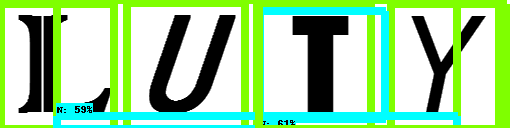

 objetos detectados:  100

>  cartel_19_GRB9.png : 


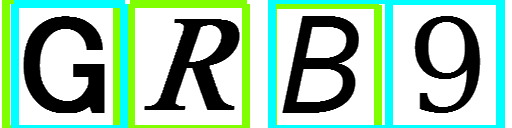

 objetos detectados:  100

>  cartel_22_QTLY2.png : 


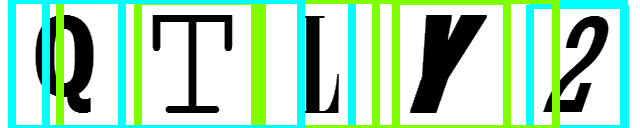

 objetos detectados:  100

>  cartel_23_15EM.png : 


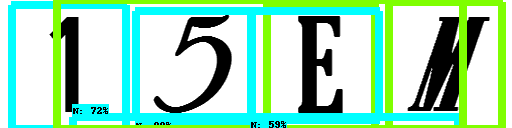

 objetos detectados:  100

>  cartel_24_PEK.png : 


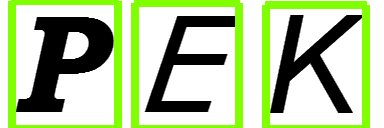

 objetos detectados:  100


In [26]:
#@title Procesar imágenes de validación usando modelo exportado

ejecutar_con_Modelo = True #@param {type:"boolean"}

if ejecutar_con_Modelo:
  # Cargar el modelo exportado 
  detection_model = tf.saved_model.load(str(modelDrive))
  print("> detection_model: ", detection_model, " cargado.")

  # muestra info de configuración
  print(detection_model.signatures['serving_default'].inputs)
  detection_model.signatures['serving_default'].output_dtypes
  detection_model.signatures['serving_default'].output_shapes

  # procesa las imágenes  
  for im in valImages:
    print("\n> ", im, ": ")
    show_inference(detection_model, valImagesPath + '/' + im)

7b) Realiza la prueba utilizando el Último Checkpoint del Entrenamiento que se ha copiado al drive:

*Nota 1: se ejecuta sólo si se exporta el último checkpoint (opcional).*

*Nota 2: en caso que se desee se puede cambiar 'checkpointCargar' para utilizar cualquiera de los checkpoints disponibles.*

In [27]:
#@title Procesar imágenes de validación usando el último checkpoint cargado
ejecutar_con_CheckPoint = False #@param {type:"boolean"}

if not exportar_ultimo_CheckPoint:
   print("No se puede ejecutar el checkpoint porque el mismo no fue exportado!")

if exportar_ultimo_CheckPoint and ejecutar_con_CheckPoint:
  ## Cargar el último checkpoint del entrenamiento
  
  # Determinar checkpoint a usar
  checkpointCargar = dirDestDriveCP + '/' + last_checkpoint

  # recupera la configuración del tipo de modelo 
  model_config = configs['model']
  detection_model = model_builder.build(
        model_config=model_config, is_training=False)

  # recupera el checkpoint del modelo
  ckpt = tf.compat.v2.train.Checkpoint(
        model=detection_model)
  ckpt.restore(checkpointCargar)

  def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
      """Detect objects in image."""

      image, shapes = model.preprocess(image)
      prediction_dict = model.predict(image, shapes)
      detections = model.postprocess(prediction_dict, shapes)

      return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

  detect_fn = get_model_detection_function(detection_model)

  print("Checkpoint ", last_checkpoint, " cargado.")

  # procesa las imágenes cargadas
  for im in valImages:

      print("\n> ",  im, ": ")

      image_path = valImagesPath + '/' + im

      # open file to process
      image = Image.open(image_path)

      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image_path)

      input_tensor = tf.convert_to_tensor(
          np.expand_dims(image_np, 0), dtype=tf.float32)
      detections, predictions_dict, shapes = detect_fn(input_tensor)

      label_id_offset = 1
      image_np_with_detections = image_np.copy()

      # Visualization of the results of a detection.
      plot_detections(image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index)



No se puede ejecutar el checkpoint porque el mismo no fue exportado!
